<font size = "+3"><strong>Blood Donation</strong></font>

<font size = "+1"><strong>Find out if a donor will give blood in March</strong></font>

<font face = "Verdana">
<p> A healthy blood is a real asset to blood tranfusion centers. One of the most important goals of blood transfusion centers is to get healthy blood that is collected from voluntary blood donors who can donate healthy blood.
<p>There are several reasons individuals donate blood, and these reasons vary among individuals. Some of these reasons include:

<ul>
<li>Donation in case of emergencies</li>
<li>Donation as an act of charity</li>
<li>Donation to relatives only</li>
<li>Donation to relatives only</li>
</ul>

<p>In this project, we'll use a classification maching learning model to find out if a donor will give make another blood donation in March, and we'll also find out the important factors that can hinder donation.

# Prepare Data

## Import

**Task: Import all necessary libraries** 

In [1]:
%load_ext autoreload

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

import plotly.express as px
import plotly.graph_objects as go

import ipywidgets as widgets
from ipywidgets import interact

import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash
import dash_daq as daq
from dash import html, dcc, Output, Input, dash

# JupyterDash.infer_jupyter_proxy_config()

**Task: Create a wrangle function to clean the dataset** 

In [3]:
def wrangle(filepath):
    #Read dataframe
    df = pd.read_csv(filepath)
    
    #Rename columns
    df.columns = ['months_since_last_donation','num_donations','volume_donated','months_since_first_donation', 'class']
    
    #Remove outliers in volumes donated
    low, high = df["volume_donated"].quantile([0.25, 0.75])
    df = df[df["volume_donated"].between(low, high)]
    
    #Drop one of the correlated features
    df.drop(columns = ["num_donations"], inplace = True)
    
    df = df.reset_index()
    
    df.drop(columns = ["index"], inplace = True)
    
    return df

df = wrangle("transfusion.data.csv")
df.head()

,months_since_last_donation,volume_donated,months_since_first_donation,class
0,4,1000,4,0
1,2,1750,14,1
2,0,750,4,0
3,2,1500,15,1
4,2,1250,11,1


**Task: Inspect the info of the dataframe `df`**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   months_since_last_donation   418 non-null    int64
 1   volume_donated               418 non-null    int64
 2   months_since_first_donation  418 non-null    int64
 3   class                        418 non-null    int64
dtypes: int64(4)
memory usage: 13.2 KB


## Explore

**Task: Check the presence of outliers in the column `volume_donated`**

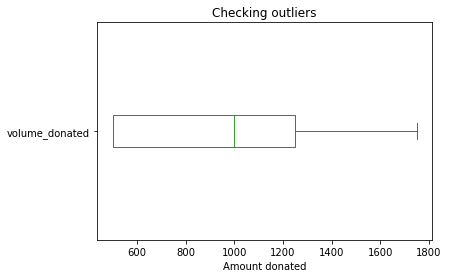

In [5]:
df["volume_donated"].plot(kind = "box", vert = False)
plt.title("Checking outliers")
plt.xlabel("Amount donated");

**Task: Check the presence of outliers in the column `months_since_first_donation`**

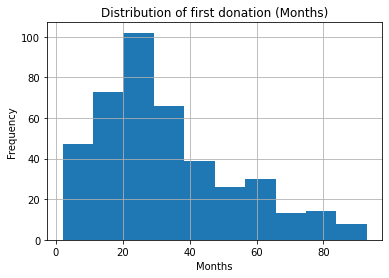

In [6]:
df["months_since_first_donation"].hist()
plt.xlabel("Months")
plt.ylabel("Frequency")
plt.title("Distribution of first donation (Months)");

**Task: Calculate the average blood donated** 

In [7]:
print("Average blood donated: ",round(df["volume_donated"].mean(), 2))

Average blood donated:  990.43


**Task: Plot a correlation heatmap of the numerical features to check for multicollinearity issues** 

In [8]:
corr = df.drop(columns = ["class"]).corr()
corr

,months_since_last_donation,volume_donated,months_since_first_donation
months_since_last_donation,1.000000,-0.129668,0.318700
volume_donated,-0.129668,1.000000,0.388263
months_since_first_donation,0.318700,0.388263,1.000000


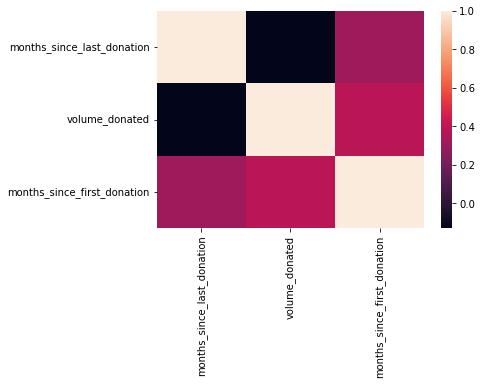

In [9]:
sns.heatmap(corr);

**Task 6: Create a boxplot to display the distributions of the `"volume_donated"` column for both groups in the `"class"` column.**

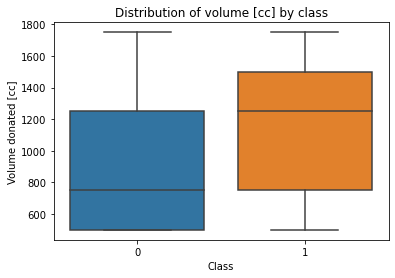

In [10]:
sns.boxplot(data = df, x = "class", y = "volume_donated")
plt.xlabel("Class")
plt.ylabel("Volume donated [cc]")
plt.title("Distribution of volume [cc] by class");

***Comment:*** The boxplot shows that the median amount of blood donated by people that will not donate in March is 500cc-1200cc, while the median amount of blood donated by people that will not donate in March is 780cc-1450cc

**Task: Check the proportion of donors that return and donors that do not**

In [11]:
major, minor = df["class"].value_counts(normalize = True)
print("Proportion that do not return: ", round(major,2))
print("Proportion that return: ", round(minor,2))

Proportion that do not return:  0.77
Proportion that return:  0.23


**Task: Visualize the above proportions**

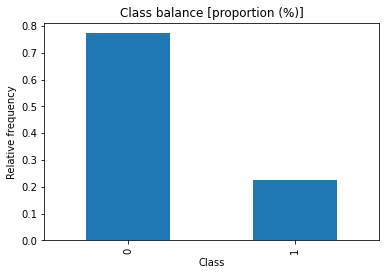

In [12]:
df["class"].value_counts(normalize = True).plot(kind = "bar")
plt.xlabel("Class")
plt.ylabel("Relative frequency")
plt.title("Class balance [proportion (%)]");

## Split

**Task: Create the feature matrix `X` and target vector `y`. The target in this case is `"class"`.**

In [13]:
target = "class"
y = df[target]
X = df.drop(columns = target)

**Task: Create a train_test_split to split the training and test data**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 32
)

# Build Model

## Baseline

**Task: Calculate the baseline accurracy score**

In [15]:
acc_score = round(y_train.value_counts(normalize = True).max(), 2)
print("Baseline Accuracy score: ", round(acc_score, 2))

Baseline Accuracy score:  0.76


**Task: Resample the dataset uisng random samplers**

In [16]:
over_sampler = RandomOverSampler(random_state = 32)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
under_sampler = RandomUnderSampler(random_state = 32)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

## Iterate & Evaluate

### Random Forest Classifier

**Task: Instantiate and train three RandomForestClassifier models**

In [17]:
model_over = RandomForestClassifier(random_state = 32)
model_over.fit(X_train_over, y_train_over)
model_under = RandomForestClassifier(random_state = 32)
model_under.fit(X_train_under, y_train_under)
model = RandomForestClassifier(random_state = 32)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=32)

**Task: Calculate the accurracy scores of the three models trained above**

In [18]:
for m in [model_over, model_under, model]:
    print(f'Train score: {round(m.score(X_train, y_train), 2)}')
    print(f'Test score: {round(m.score(X_test, y_test), 2)}\n')

Train score: 0.92
Test score: 0.63

Train score: 0.71
Test score: 0.5

Train score: 0.94
Test score: 0.68



**Task: Instantiate a RandomForestClassifier model**

In [19]:
rand_clf = RandomForestClassifier(random_state = 32)

**Task: Calculate the Cross Validation scores of the best sample**

In [20]:
cv_score = cross_val_score(rand_clf, X_train, y_train, n_jobs = -1, cv = 5)
cv_score

array([0.71641791, 0.7761194 , 0.7761194 , 0.73134328, 0.62121212])

**Task: Create a dictionary of parameters**

In [21]:
params = {
    "n_estimators" : range(25, 101, 25),
    "max_depth" : range(10, 60, 10)
}
params

{'n_estimators': range(25, 101, 25), 'max_depth': range(10, 60, 10)}

**Task: Tune the hyperparameters using a GridSearchCV**

In [22]:
rand_model = GridSearchCV(rand_clf, param_grid = params, n_jobs = -1, cv = 5, verbose = 1)
rand_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=32), n_jobs=-1,
             param_grid={'max_depth': range(10, 60, 10),
                         'n_estimators': range(25, 101, 25)},
             verbose=1)

**Task: Visualize the Confusion Matrix**

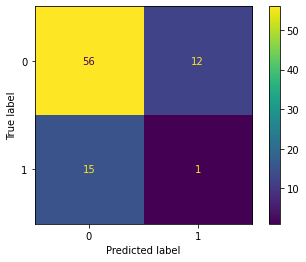

In [23]:
ConfusionMatrixDisplay.from_estimator(rand_model, X_test, y_test);

**Task: Print the classification report**

In [24]:
print(classification_report(y_test, rand_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81        68
           1       0.08      0.06      0.07        16

    accuracy                           0.68        84
   macro avg       0.43      0.44      0.44        84
weighted avg       0.65      0.68      0.67        84



### Gradient Boosting Classifier

**Task: Instantiate and train three GradientBoostingClassifier models**

In [25]:
model_over = GradientBoostingClassifier()
model_over.fit(X_train_over, y_train_over)
model_under = GradientBoostingClassifier()
model_under.fit(X_train_under, y_train_under)
model = GradientBoostingClassifier()
model.fit(X_train, y_train)


GradientBoostingClassifier()

**Task: Calculate the accurracy scores of the three models trained above**

In [26]:
for m in [model_over, model_under, model]:
    print(f'Train score: {round(m.score(X_train, y_train), 2)}')
    print(f'Test score: {round(m.score(X_test, y_test), 2)}\n')

Train score: 0.84
Test score: 0.58

Train score: 0.73
Test score: 0.5

Train score: 0.86
Test score: 0.69



**Task: Instantiate a GradientBoostingClassifier model**

In [27]:
grad_clf = GradientBoostingClassifier()

**Task: Tune the hyperparameters using a GridSearchCV**

In [28]:
grad_model = GridSearchCV(grad_clf, param_grid = params, n_jobs = -1, cv = 5, verbose = 1)
grad_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(10, 60, 10),
                         'n_estimators': range(25, 101, 25)},
             verbose=1)

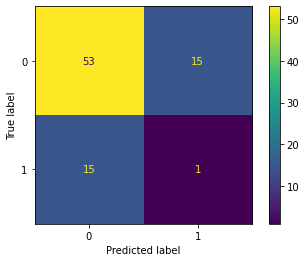

In [29]:
ConfusionMatrixDisplay.from_estimator(grad_model, X_test, y_test);

In [30]:
print(classification_report(y_test, grad_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        68
           1       0.06      0.06      0.06        16

    accuracy                           0.64        84
   macro avg       0.42      0.42      0.42        84
weighted avg       0.64      0.64      0.64        84



**Task: Generate the cross validation results of the best model**

In [31]:
cv_result = pd.DataFrame(rand_model.cv_results_)
cv_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.082637,0.012849,0.013243,0.012916,10,25,"{'max_depth': 10, 'n_estimators': 25}",0.701493,0.746269,0.791045,0.701493,0.666667,0.721393,0.043028,19
1,0.151519,0.024281,0.018899,0.006177,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.716418,0.761194,0.776119,0.686567,0.681818,0.724423,0.038307,6
2,0.206529,0.003240,0.021873,0.007655,10,75,"{'max_depth': 10, 'n_estimators': 75}",0.716418,0.761194,0.791045,0.716418,0.651515,0.727318,0.047313,5
3,0.286241,0.011803,0.023636,0.006892,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.716418,0.761194,0.776119,0.701493,0.636364,0.718318,0.049361,20
4,0.073213,0.012439,0.012499,0.006250,20,25,"{'max_depth': 20, 'n_estimators': 25}",0.686567,0.746269,0.791045,0.731343,0.666667,0.724378,0.044119,7


**Task: Print the best estimator of the  model**

In [32]:
rand_model.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=75, random_state=32)

**Task: Visualize the relationship between the mean fit time and the number of estimators**

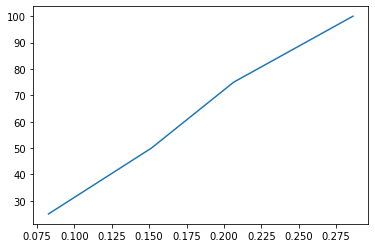

In [33]:
mask_estimator = cv_result[cv_result["param_max_depth"] == 10]
plt.plot(
    mask_estimator["mean_fit_time"],mask_estimator["param_n_estimators"]
);

**Task: Visualize the relationship between the mean fit time and the max depth**

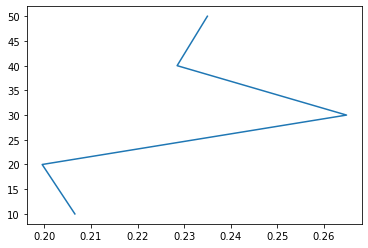

In [34]:
mask_estimator = cv_result[cv_result["param_n_estimators"] == 75]
plt.plot(
    mask_estimator["mean_fit_time"], mask_estimator["param_max_depth"]
);

## Communicate

**Task: Create an interactive widget to generate predictions**

In [35]:
def make_cnf_matrix(threshold):
    y_pred = rand_model.predict_proba(X_test)[:,-1] > threshold
    
    conf_matrix = confusion_matrix(y_test,y_pred)
    tp, fp, fn, tn = conf_matrix.ravel()    
    print(f'{round(tn/(tp + tn) * 100, 2)}% will come back to donate')
    print(f'Precision = {round(tp/(tp + fp),2)}')
    print(f'Recall = {round(tp/(tp + fn),2)}')
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar = False)

thresh_widget = widgets.FloatSlider(max = 1, min = 0, value = 0.5, step = 0.05)
interact(make_cnf_matrix, threshold = thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

**Task: Generate the feature importances**

In [36]:
feat_imp = rand_model.best_estimator_.feature_importances_
feat_imp

array([0.2832393 , 0.15615241, 0.56060829])

**Task: Create a series of feature importances (odd ratio)**

In [37]:
odds = pd.Series(feat_imp, index = X_train.columns).sort_values(ascending = True)
odds

volume_donated                 0.156152
months_since_last_donation     0.283239
months_since_first_donation    0.560608
dtype: float64

**Task: Visualize the feature importance (odd's ratio)**

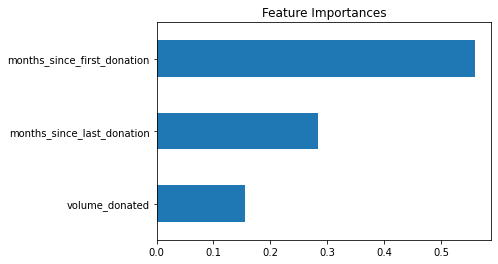

In [38]:
odds.plot(kind = "barh")
plt.title("Feature Importances");

# Findings

<font face = "Verdana">
<p>
In order of importance, the following factors would prevent donors from making another donation:<br>
<ul>
<li>Months since first donation</li>
<li>Months since last donation</li>
<li>Volume donated</li>
</ul>

## Deployment

In [39]:
# app = JupyterDash(__name__)
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

In [40]:
def build_model(randForest = "Random Forest Classifier"):
    target = "class"
    y = df[target]
    X = df.drop(columns = target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)
    params = {"n_estimators" : range(25, 101, 25),"max_depth" : range(10, 60, 10)}
    
    if randForest == "Random Forest Classifier":
        clf = RandomForestClassifier(random_state = 32)
    else:
        clf = GradientBoostingClassifier()
        
    model = GridSearchCV(clf, param_grid = params, n_jobs = -1, cv = 5, verbose = 1)
    
    return model

In [41]:
@app.callback(
    Output("thresh-result", "children"), 
    Input("model-drop","value"),
    Input("thresh-slider","value")
)

def generate_predictions(randForest = "Random Forest Classifier", threshold = 0.5):
    model = build_model(randForest)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,-1] > threshold
    conf_matrix = confusion_matrix(y_test,y_pred)
    tp, fp, fn, tn = conf_matrix.ravel()    
    output_text = html.H3(f'{round(tn/(tp + tn) * 100, 2)}% will come back to donate')

    return output_text

In [42]:
@app.callback(
    Output("bar-chart","figure"), Input("model-drop","value")
)
def serve_features(randForest = "Random Forest Classifier"):
    model = build_model(randForest)
    model.fit(X_train, y_train)
    feat_imp = model.best_estimator_.feature_importances_
    odds = pd.Series(feat_imp, index = X_train.columns).sort_values(ascending = True)
    index = [odd.replace("_"," ").title() for odd in odds.index.to_list()]
    fig = px.bar(x = odds, y = index, orientation = "h")
    fig.update_layout(xaxis_title = "Odd's Ratio", yaxis_title = "Features")
    return fig

In [ ]:
# Graphs
trends = ["In this project, we'll use classification models to find out the proportion of donors that will make another blood donation in March",
          "."]
newlabels = {'0' : 'Will not Return', '1': 'Will Return'}
histogram = px.histogram(X, x = 'volume_donated', color = y, nbins=10, barmode = 'group', title = "Distribution of Volume of Blood by Class")
histogram.update_layout(xaxis_title = "Volume of Blood", yaxis_title = "Frequency", legend_title = "Legend")
histogram.for_each_trace(lambda t: t.update(name = newlabels[t.name], legendgroup = newlabels[t.name],
                                hovertemplate = t.hovertemplate.replace(t.name, newlabels[t.name]) ))
columns = df.columns.to_list()
columns.remove('class')

app.layout = html.Div([
    html.Br(),
    html.H2('Project: Blood Donation'),
    dbc.Tabs([
    dbc.Tab([
        dbc.Row([
            dbc.Col([
                html.Br(),
                html.Div([html.H3("Models")]),
                html.Div([
                    dcc.Dropdown(
                    options = ["Random Forest Classifier", "Gradient Boosting Classifier"],
                        value = "Random Forest Classifier",
                    id = "model-drop")
                ]
                ),html.Br(),
                html.Div([html.H3("Threshold")]),html.Br(),
                dcc.Slider(
                max = 1, min = 0, value = 0.5, step = 0.1,
                id = "thresh-slider"
                ),
                html.Div(id = "thresh-result")
                
            ], width = 3, style = {'margin-left':'15px', 'margin-top':'7px', 'margin-right':'15px'}),
            dbc.Col([
                html.Div([html.H3("Predictions")]),
                html.Div([html.H4("Feature Importances")]),
                dcc.Graph(id = "bar-chart", figure = serve_features()),
                html.Div([html.H4("Percentage of Potential Returnees:")]),
                html.Div(id = "thresh-result"),
                html.Br(),
                html.Div([html.Div([dcc.Graph(figure=histogram)])])
            ], width = 6, style = {'margin-left':'15px', 'margin-top':'7px', 'margin-right':'15px'})
        ])
    ], label='Model Predictions'),
    dbc.Tab([
        html.Ul([
            html.Br(),
            html.Li('In this project, we used classification models to find out the proportion of donors that will make another blood donation in March'),
            html.Li('We also found the important factors that can hinder donation'),
            html.Li(['GitHub repo: ',
                     html.A('https://github.com/GentRoyal/blood_donation',
                            href='https://github.com/GentRoyal/blood_donation')])
            ])
        ], label='Project Info')
    ])],style = {'margin-left':'15px', 'margin-top':'7px', 'margin-right':'15px'}
    )
                             

# app.run_server(mode='external', debug=False)
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: on
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
